In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from copy import deepcopy
from pconv.model import PConvUnet
from pconv.util import ImageChunker
from pycocotools.coco import COCO
from skimage.io import imread

Using TensorFlow backend.


In [2]:
data_dir = '../data'
data_type = 'val2017'
model_dir = '../models/base_pconv_imagenet'
model_path = '{}/pconv_imagenet.26-1.07.h5'.format(model_dir)

In [3]:
coco = COCO('{}/raw/annotations/instances_{}.json'.format(data_dir, data_type))
category_ids = coco.getCatIds(supNms=['person', 'vehicle'])

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


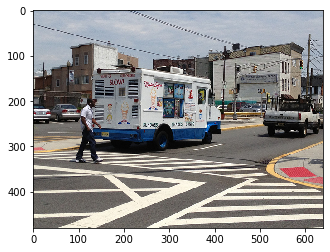

In [4]:
image_id = 393226
image_info = coco.loadImgs([image_id])[0]
image = imread('{}/raw/images/{}/{}'.format(data_dir, data_type, image_info['file_name']))
plt.imshow(image)

In [5]:
annotation_ids = coco.getAnnIds(imgIds=[image_id], catIds=category_ids)
annotations = coco.loadAnns(annotation_ids)

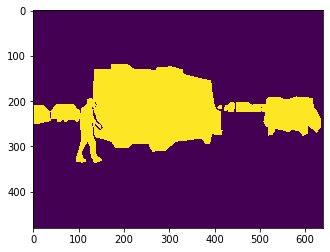

In [6]:
mask = np.zeros(image.shape[:2], dtype='uint8')
for annotation in annotations:
    mask = cv.bitwise_or(mask, coco.annToMask(annotation))
plt.imshow(mask)

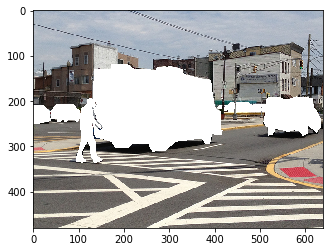

In [7]:
mask = cv.cvtColor(mask, cv.COLOR_GRAY2BGR)
mask = np.ones(mask.shape) - mask
image = image / 255
image[mask==0] = 1
plt.imshow(image)

In [8]:
model = PConvUnet(vgg_weights='', inference_only=True)
model.load(model_path, train_bn=False)

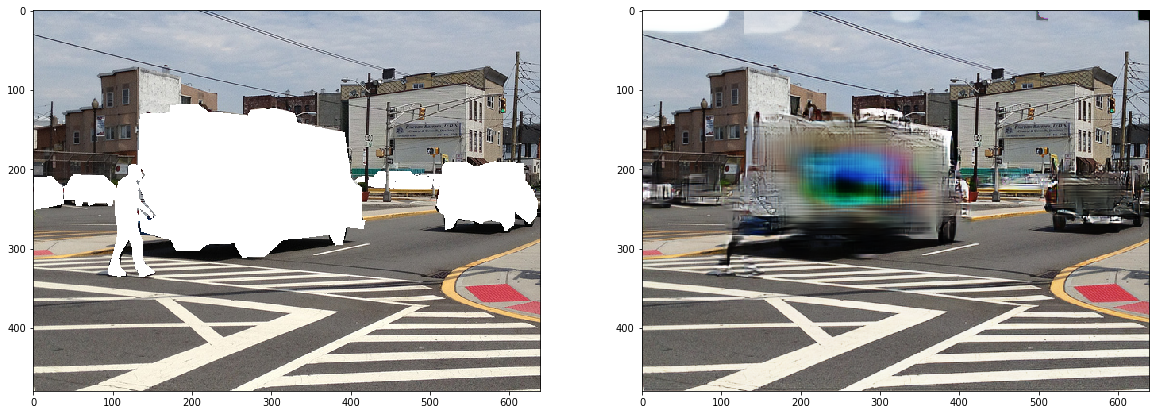

In [9]:
chunker = ImageChunker(512, 512, 30)

def plot_images(images, s=5):
    _, axes = plt.subplots(1, len(images), figsize=(s*len(images), s))
    if len(images) == 1:
        axes = [axes]
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.show()

chunked_images = chunker.dimension_preprocess(deepcopy(image))
chunked_masks = chunker.dimension_preprocess(deepcopy(mask))
pred_imgs = model.predict([chunked_images, chunked_masks])
reconstructed_image = chunker.dimension_postprocess(pred_imgs, image)

plot_images([image, reconstructed_image], s=10)
